In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from skgarden import MondrianForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle
from sklearn.metrics import mean_squared_error

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pylab import rcParams

import pandas as pd
import time
from sklearn.metrics import r2_score
import rrcf

C:\Users\HakkyuKim\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\HakkyuKim\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def score_for_res(pred, trueval) :
    u2 = (pred-trueval)**2
    v2 = (trueval-trueval.mean())**2
    
    return 1-(u2.sum()/v2.sum())

In [3]:
def partial_train(mtr, X_test, y_test):
    y_pred, y_std = mtr.predict(X_test, return_std=True)
    mtr.partial_fit(X_test, y_test)
    #print('pred : %f, std: %f, y: %f'%(y_pred, y_std, y_test))
    return y_pred, y_std

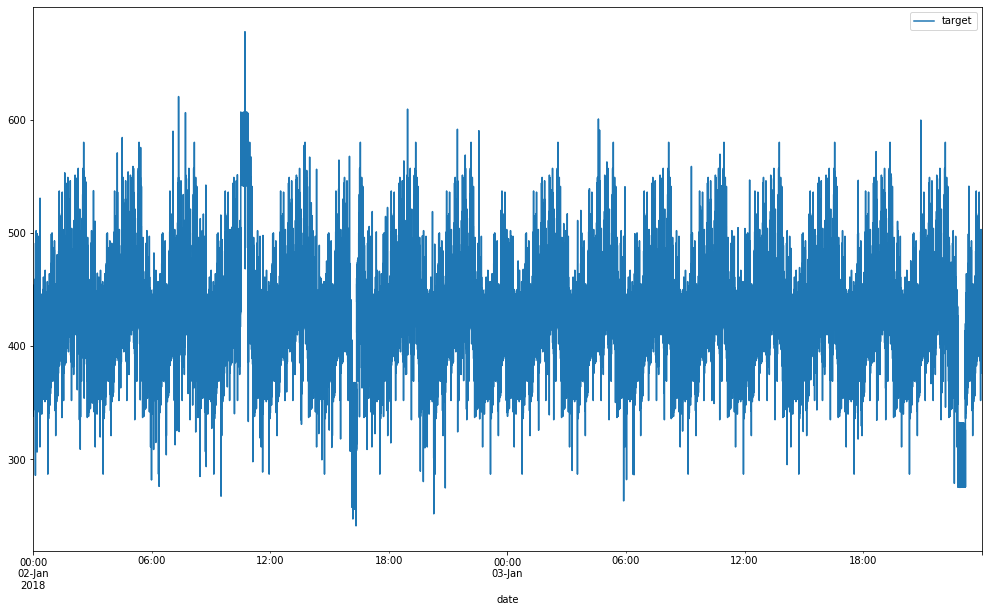

In [4]:
network = pd.read_csv('C:/Users/HakkyuKim/Desktop/yeonwoo/challenge/intial_trainig_stage.csv', index_col='date', parse_dates=['date'])
network.head()

rcParams['figure.figsize'] = 17,10
network.describe()
network.plot()

In [5]:
#construct forest of empty RCTrees

num_trees = 40
shingle_size = 60
tree_size = 256


forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

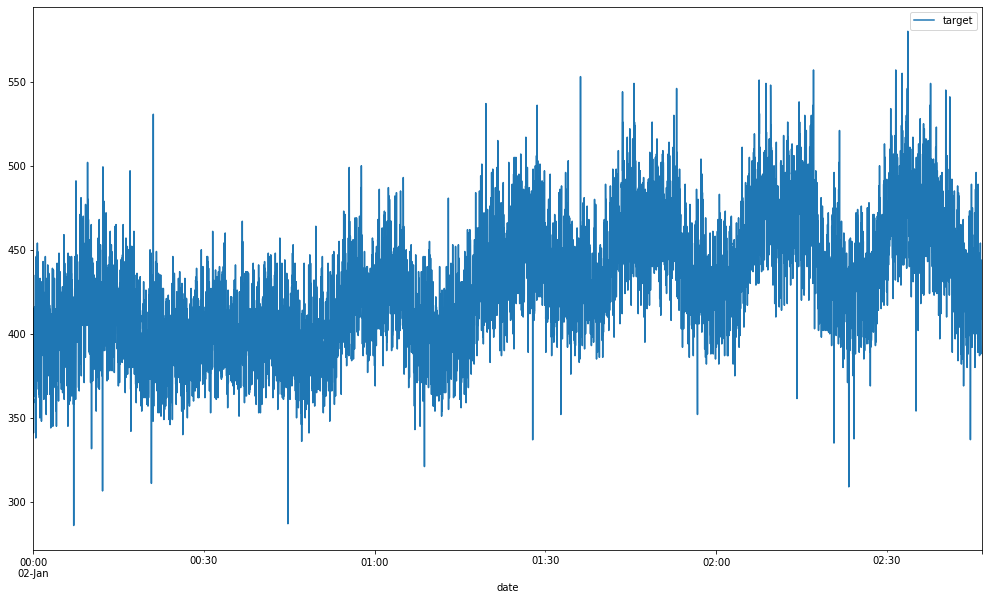

In [6]:
#train data 정제
ntw_clean = network.copy()

train_len = 10000
ntw_clean = ntw_clean[:train_len]

avg_codisp = {}
train_mean = ntw_clean.mean()

ntw_clean.plot()

In [ ]:
for index in range(0, train_len) :
    point = ntw_clean[index:index+1] #get one by one
    
    for tree in forest :
        if len(tree.leaves) > tree_size :
            tree.forget_point(index-tree_size)
            
        tree.insert_point(point, index=index)
        
        if not index in avg_codisp :
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
    #avg_codisp은 (각 tree 이 point를 anomaly로 생각하는 정도)의 평균
    mean = np.array(list(avg_codisp.values())).mean()
    std = np.array(list(avg_codisp.values())).std()
        
    z = (avg_codisp[index] - mean)/std
    if z > 3.0 or z < -3.0 :
        #if abs(z-score) is over 3.0
        #replace the value with the mean of training data
        
        ntw_clean.iloc[index] = train_mean
        


In [ ]:

ntw_clean.plot()


In [ ]:
avg_codisp

In [ ]:
#train set만들기
tmp = ntw_clean.shift(1)
tmp2 = ntw_clean.shift(2)
tmp3 = ntw_clean.shift(3)

ntw_prev = ntw_clean.copy()
ntw_prev['prev1'] = tmp['target']
ntw_prev['prev2'] = tmp2['target']
ntw_prev['prev3'] = tmp3['target']

ntw_prev = ntw_prev[4:]
ntw_prev.tail()

In [ ]:
X = ntw_prev[['prev1', 'prev2', 'prev3']]
y = ntw_prev['target']

#training은 clean한 data로, test는 clean하지 않은 data를 rrcf로 다시 정제하면서 진행할거임
X_train = X;
y_train = y;
train_len = len(X_train)

xt = [network[10000:10001], network[10001:10002], network[10002:10003]]



In [ ]:
mfr = MondrianForestRegressor(random_state = 1, n_estimators=100, bootstrap=True)
mfr.partial_fit(X_train, y_train)

prediction = np.array()
stdeviation = np.array()

#일단 Test mean은 train mean과 같게 시작
test_sum = ntw_clean.sum()
test_num = ntw_clean.size


In [ ]:
for i in range(0, 10000) :
    yp = yt
    if (i == 0) : 
        yp = None
    
    yt = network[10003+i:10003+i+1]
    
    #train의 index가 9999에서 끝났으니까, 10000부터 시작
    index = i+10000 
    #yt의 anomaly여부 판단
    for tree in forest :
        if len(tree.leaves) > tree_size :
            tree.forget_point(index-tree_size)
            
        tree.insert_point(point, index=index)
        
        if not index in avg_codisp :
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
    #avg_codisp은 (각 tree 이 point를 anomaly로 생각하는 정도)의 평균
    mean = np.array(list(avg_codisp.values())).mean()
    std = np.array(list(avg_codisp.values())).std()
        
    z = (avg_codisp[index] - mean)/std
    if z > 3.0 or z < -3.0 :
        #if abs(z-score) is over 3.0
        #replace the value with the mean of training data
        ntw_clean.iloc[index] = test_sum/test_num
    
    y_pred, y_std = partial_train(mfr, xt, yt)
    #과거 3개만 저장
    np.roll(xt, -1)
    xt[2] = yt
    
    test_sum += yt
    test_num += 1
    
    prediction = np.append(prediction, [y_pred])
    stdeviation = np.append(stdeviation, [y_std])
    
    